In [77]:
%load_ext autoreload
%autoreload 2
import sys
import os
project_root = os.path.abspath("/Users/joschua/repos/harris_lab/hypnose/hypnose-analysis")
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import numpy as np 
import utils
from utils import *
from pathlib import Path
import harp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
from functools import reduce
from src.processing import detect_settings
import src.processing.detect_stage as detect_stage_module

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Loading experiments --> just define the SUBJID and DATE
root = load_experiment(32, 20250908, index=0) #can add index for multiple experiments; index=0 as default
stage = detect_stage_module.detect_stage(root)

Using subject directory: /Volumes/harris/hypnose/rawdata/sub-032_id-107
Loaded experiment 0: /Volumes/harris/hypnose/rawdata/sub-032_id-107/ses-83_date-20250908/behav/2025-09-08T10-49-42
Detected stage: QuintupleA_Stage5B
No hidden rule index found


In [87]:
data = load_all_streams(root)

Loading data streams from: /Volumes/harris/hypnose/rawdata/sub-032_id-107/ses-83_date-20250908/behav/2025-09-08T10-49-42
Loaded heartbeat data
Calculated real-time offset: 44446 days, 9:45:23
Created timestamp interpolation mapping
Loaded digital_input_data
Loaded output_set
Loaded output_clear
Loaded olfactometer_valves_0
Loaded olfactometer_valves_1
Loaded olfactometer_end_0
Loaded analog_data
Loaded flow_meter
Loaded video_data
Loaded pulse_supply_1
Loaded pulse_supply_2
Created odour_led

Applying time corrections to all data streams...
Applied correction to digital_input_data
Applied correction to output_set
Applied correction to output_clear
Applied correction to olfactometer_valves_0
Applied correction to olfactometer_valves_1
Applied correction to olfactometer_end_0
Applied correction to analog_data
Applied correction to flow_meter
Applied correction to video_data
Applied correction to pulse_supply_1
Applied correction to pulse_supply_2
Applied correction to odour_led

Data loa

In [88]:
events = load_experiment_events(root)

Loading experiment events...
Loaded heartbeat data for timing synchronization
Calculated real-time offset: 44446 days, 9:45:23
Created timestamp interpolation mapping
Found 2 experiment event files
Processing event file: ExperimentEvents_1904-01-01T02-00-00.csv with 713 rows
Using Seconds column with interpolation
Applied real-time offset: 44446 days, 9:45:23
Found Value column with values: ['EndInitiation' 'Reset' 'ChooseRandomSequence' 'SampleRewardCondition'
 'InitiationSequence' 'AwaitReward']
Found 133 EndInitiation events
Found 133 InitiationSequence events
Found 133 Reset events
Found 48 AwaitReward events
Found 133 SampleRewardCondition events
Found 133 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-01-01T03-00-00.csv with 384 rows
Using Seconds column with interpolation
Applied real-time offset: 44446 days, 9:45:23
Found Value column with values: ['EndInitiation' 'Reset' 'ChooseRandomSequence' 'SampleRewardCondition'
 'InitiationSequence' 'AwaitReward

In [89]:
odor_map = load_odor_mapping(root, data)
print("Data streams loaded:", list(data.keys()))
print("Event types loaded:", list(events.keys()))
print("Odor mapping:", odor_map['odour_to_olfactometer_map'])

Loading odor mapping from session settings...
Loaded session settings
Found 10 valve configurations for olfactometer 0
Found 10 valve configurations for olfactometer 1
Created valve-to-command mapping: {'00': 3, '01': 7, '02': 5, '03': 6, '10': 4, '11': 8, '12': 9, '13': 2}
Created odor mapping: [['OdorA', 'OdorE', 'OdorC', 'OdorD'], ['OdorB', 'OdorF', 'OdorG', 'Purge']]
Data streams loaded: ['heartbeat', 'real_time_offset', 'timestamp_to_time', 'interpolate_time', 'digital_input_data', 'output_set', 'output_clear', 'olfactometer_valves_0', 'olfactometer_valves_1', 'olfactometer_end_0', 'analog_data', 'flow_meter', 'video_reader', 'video_data', 'pulse_supply_1', 'pulse_supply_2', 'odour_led', 'behavior_reader', 'olfactometer_reader']
Event types loaded: ['combined_initiation_sequence_df', 'combined_end_initiation_df', 'combined_await_reward_df', 'combined_reset_df', 'combined_choose_random_sequence_df', 'combined_sample_reward_condition_df']
Odor mapping: [['OdorA', 'OdorE', 'OdorC', '

In [90]:
trial_counts = detect_trials(data, events, root, verbose=True)

TRIAL DETECTION - METHOD 3: Simplified
Parameters: minimum_sampling_time=350.0ms, sample_offset_time=200.0ms

InitiationSequence 0: 2025-09-08 11:53:22.060992
  Found 4 poke periods
    Starting attempt 1 at 2025-09-08 11:53:22.610272
      Poke 1: 193.1ms (total: 193.1ms)
      Gap to poke 2: 484.9ms (≥200.0ms - sequence ends)
      FAILED: 193.1ms continuous poke (<350.0ms)
    Starting attempt 2 at 2025-09-08 11:53:23.288224
      Poke 2: 379.9ms (total: 379.9ms)
      SUCCESS: 379.9ms continuous poke (≥350.0ms)

InitiationSequence 1: 2025-09-08 11:53:28.240992
  Found 7 poke periods
    Starting attempt 1 at 2025-09-08 11:55:09.420864
      Poke 1: 48.0ms (total: 48.0ms)
      Poke 2: gap 67.7ms + 43.5ms (total: 159.2ms)
      Gap to poke 3: 443.1ms (≥200.0ms - sequence ends)
      FAILED: 159.2ms continuous poke (<350.0ms)
    Starting attempt 2 at 2025-09-08 11:55:10.023168
      Poke 3: 388.8ms (total: 388.8ms)
      SUCCESS: 388.8ms continuous poke (≥350.0ms)

InitiationSequenc

In [91]:
trial_outcomes_complete = classify_and_analyze_with_response_times(data, events, trial_counts, odor_map, stage, root)

CLASSIFYING TRIAL OUTCOMES WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS
Sample offset time: 200.0 ms
Minimum sampling time: 350.0 ms
Response time window: 99999.0 s
No Hidden Rule Location found in sequence name: QuintupleA_Stage5B. Proceeding without Hidden Rule analysis.
Found 1028 total valve activations (excluding Purge)
Analyzing 202 initiated trials...
Found 82 AwaitReward events
Found 80 total supply port activities

TRIAL CLASSIFICATION RESULTS WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS:
Hidden Rule Location: Position None (index None)

Total attempts: 486
-- Non-initiated sequences (total): 284 (58.4%)
    -- Position 1 attempts within trials 92 (32.4%)
    -- Baseline non-initiated sequences 192 (67.6%)
-- Initiated sequences (trials): 202 (41.6%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 82 (40.6%)
   -- Hidden Rule trials (HR): 0 (0.0%)
   -- Hidden Rule Missed (HR_missed): 0 (0.0%)
-- Aborted sequences: 120 (59.4%)
   -- Aborted Hidden Rule trials (HR): 0 (0

In [92]:
cls = trial_outcomes_complete['classification']
meta = {'stage': stage.get('stage_name') if isinstance(stage, dict) else str(stage)}
save_dir = save_session_analysis_results(cls, root, session_metadata=meta, verbose=True)

Saved analysis results to:
  /Volumes/harris/hypnose/derivatives/sub-032_id-107/ses-83_date-20250908/saved_analysis_results
- tables written: 9


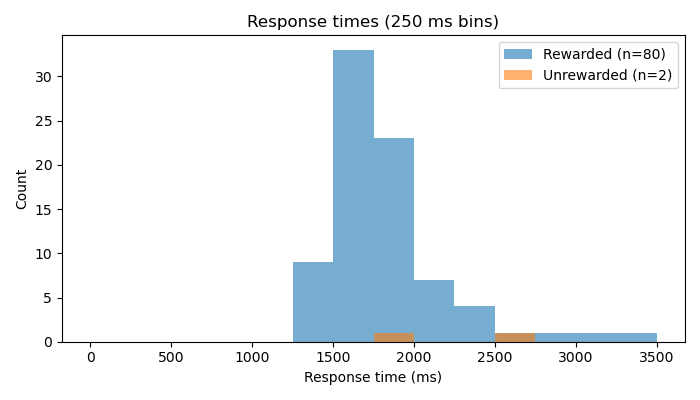

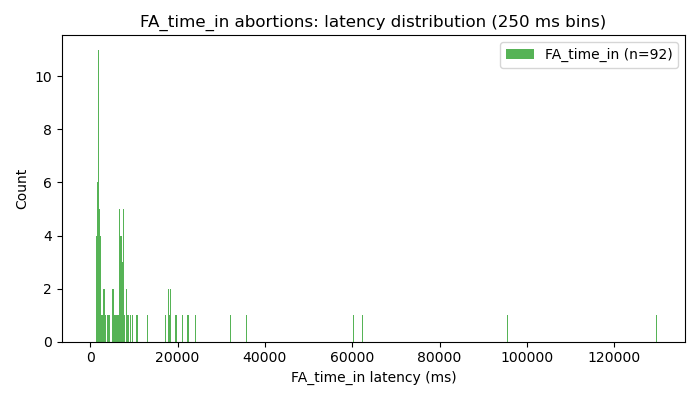

In [93]:
%matplotlib ipympl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rta = trial_outcomes_complete['response_time_analysis']
cls = trial_outcomes_complete['classification']
df_ab = cls.get('aborted_sequences_detailed', pd.DataFrame())

# Arrays from analyzer
rew = np.asarray(rta.get('rewarded_response_times', []), dtype=float)
unr = np.asarray(rta.get('unrewarded_response_times', []), dtype=float)

bin_ms = 250
max_ms_ru = max(rew.max() if rew.size else 0, unr.max() if unr.size else 0) or bin_ms
bins_ru = np.arange(0, math.ceil(max_ms_ru / bin_ms) * bin_ms + bin_ms, bin_ms)

plt.figure(figsize=(7,4))
plt.hist(rew, bins=bins_ru, alpha=0.6, label=f'Rewarded (n={len(rew)})', color='#1f77b4')
plt.hist(unr, bins=bins_ru, alpha=0.6, label=f'Unrewarded (n={len(unr)})', color='#ff7f0e')
plt.xlabel('Response time (ms)')
plt.ylabel('Count')
plt.title('Response times (250 ms bins)')
plt.legend()
plt.tight_layout()
plt.show()

# FA_time_in abortions (latency from abortion to first reward poke)
fa_in = np.array([], dtype=float)
if not df_ab.empty and 'fa_label' in df_ab and 'fa_latency_ms' in df_ab:
    fa_in = pd.to_numeric(
        df_ab.loc[df_ab['fa_label'] == 'FA_time_in', 'fa_latency_ms'],
        errors='coerce'
    ).dropna().astype(float).to_numpy()

max_ms_fa = fa_in.max() if fa_in.size else bin_ms
bins_fa = np.arange(0, math.ceil(max_ms_fa / bin_ms) * bin_ms + bin_ms, bin_ms)

plt.figure(figsize=(7,4))
plt.hist(fa_in, bins=bins_fa, alpha=0.8, color='#2ca02c', label=f'FA_time_in (n={len(fa_in)})')
plt.xlabel('FA_time_in latency (ms)')
plt.ylabel('Count')
plt.title('FA_time_in abortions: latency distribution (250 ms bins)')
plt.legend()
plt.tight_layout()
plt.show()

# Testing of new functions

In [55]:
import pandas as pd

cls = trial_outcomes_complete['classification']
aborted = cls.get('aborted_sequences_detailed', pd.DataFrame())

if aborted is None or aborted.empty:
    print("No aborted_sequences_detailed available.")
else:
    # Get HR-aborted trial IDs from the classification
    hr_ab_df = None
    for k in ['aborted_sequences_HR', 'aborted_HR_sequences', 'aborted_hidden_rule_sequences']:
        if isinstance(cls.get(k), pd.DataFrame) and not cls[k].empty and 'trial_id' in cls[k]:
            hr_ab_df = cls[k]
            break

    if hr_ab_df is not None:
        hr_aborted_ids = set(hr_ab_df['trial_id'])
    else:
        # Fallback: if abortion_classification stored a boolean flag per trial
        if 'hit_hidden_rule' in aborted.columns:
            hr_aborted_ids = set(aborted.loc[aborted['hit_hidden_rule'] == True, 'trial_id'])
        else:
            hr_aborted_ids = set()  # no HR flag available

    if not hr_aborted_ids:
        print("No HR-aborted trial IDs available in classification (cannot reconcile counts).")
    else:
        # Filter to HR abortions at position 1
        hr_pos = int(cls.get('hidden_rule_position', 1))
        sub = aborted[(aborted['trial_id'].isin(hr_aborted_ids)) & (aborted['last_odor_position'] == 1)].copy()

        # Normalize FA labels and summarize
        def norm_fa(v):
            s = str(v).strip().lower()
            if s in ('fa_time_in','fa in','fa_in','in'): return 'FA_time_in'
            if s in ('fa_time_out','fa out','fa_out','out'): return 'FA_time_out'
            if s in ('fa_late','late'): return 'FA_late'
            return 'nFA'
        sub['fa_label'] = sub['fa_label'].apply(norm_fa)
        sub['fa_latency_ms'] = pd.to_numeric(sub['fa_latency_ms'], errors='coerce')

        total = len(sub)
        print(f"HR abortions at position 1: n={total}")
        counts = sub['fa_label'].value_counts().reindex(['nFA','FA_time_in','FA_time_out','FA_late'], fill_value=0)
        for k, v in counts.items():
            pct = (v/total*100.0) if total else 0.0
            print(f"  - {k}: {v} ({pct:.1f}%)")

        # List trials
        sub = sub.sort_values('abortion_time')
        for _, r in sub[['trial_id','abortion_time','fa_label','fa_latency_ms']].iterrows():
            print(f"  trial={r['trial_id']} | abort={pd.to_datetime(r['abortion_time']).isoformat()} | {r['fa_label']}"
                  f"{'' if pd.isna(r['fa_latency_ms']) else f' | lat={r['fa_latency_ms']:.1f} ms'}")

        display(sub[['trial_id','last_odor_position','abortion_type','fa_label','fa_latency_ms','abortion_time']].reset_index(drop=True))

HR abortions at position 1: n=4
  - nFA: 0 (0.0%)
  - FA_time_in: 3 (75.0%)
  - FA_time_out: 1 (25.0%)
  - FA_late: 0 (0.0%)
  trial=39 | abort=2025-09-07T14:47:16.143008 | FA_time_in | lat=1808.4 ms
  trial=139 | abort=2025-09-07T16:21:42.175936 | FA_time_in | lat=1613.4 ms
  trial=185 | abort=2025-09-07T17:29:42.404160 | FA_time_in | lat=1651.1 ms
  trial=190 | abort=2025-09-07T17:33:31.910560 | FA_time_out | lat=2206.4 ms


,trial_id,last_odor_position,abortion_type,fa_label,fa_latency_ms,abortion_time
0,39,1,reinitiation_abortion,FA_time_in,1808.384,2025-09-07 14:47:16.143008
1,139,1,reinitiation_abortion,FA_time_in,1613.440,2025-09-07 16:21:42.175936
2,185,1,reinitiation_abortion,FA_time_in,1651.136,2025-09-07 17:29:42.404160
3,190,1,reinitiation_abortion,FA_time_out,2206.400,2025-09-07 17:33:31.910560


In [ ]:

cls = trial_outcomes_complete['classification']

# Pick the HR-timeout table (singular vs plural alias)
df = cls.get('completed_sequence_HR_rewarded')
if (df is None or df.empty) and 'completed_sequences_HR_rewarded' in cls:
    df = cls['completed_sequences_HR_rewarded']

if df is None or df.empty or 'trial_id' not in df:
    print("No HR timeout trials found.")
else:
    df = df.copy()

    # Session start for relative seconds
    di = data.get('digital_input_data', {})
    streams = [di.get(k, pd.Series(dtype=bool)) for k in ('DIPort0','DIPort1','DIPort2')]
    try:
        session_start = min([s.index[0] for s in streams if hasattr(s, 'empty') and not s.empty])
    except Exception:
        session_start = None

    # Choose best available timestamp per trial
    cand_cols = ['response_window_end', 'sequence_end', 'trial_end', 'await_reward_time']
    for c in cand_cols:
        if c in df:
            df[c] = pd.to_datetime(df[c], errors='coerce')

    def pick_time(row):
        for c in cand_cols:
            v = row.get(c)
            if pd.notna(v):
                return v
        return pd.NaT

    df['event_time'] = df.apply(pick_time, axis=1)
    if session_start is not None:
        df['event_time_s'] = (df['event_time'] - session_start).dt.total_seconds()
    else:
        df['event_time_s'] = pd.NA

    df = df.sort_values('event_time')
    print(f"HR timeout trials: n={len(df)}")
    for _, r in df[['trial_id','event_time','event_time_s']].iterrows():
        ts = r['event_time']
        rel = r['event_time_s']
        print(f"  trial={r['trial_id']} at {ts.isoformat() if pd.notna(ts) else 'NaT'}"
              f"{'' if pd.isna(rel) else f' (t={rel:.3f}s)'}")

    # Optional table view
    display(df[['trial_id','event_time','event_time_s'] + [c for c in cand_cols if c in df]].reset_index(drop=True))

# Debugging Functions:



In [70]:
def check_data_availability(data, events, odor_map):
    """Quick check of all data streams for availability and content"""
    
    print("=" * 60)
    print("DATA AVAILABILITY CHECK")
    print("=" * 60)
    
    # Check main data streams
    print("\n📊 DATA STREAMS:")
    for key, value in data.items():
        if isinstance(value, pd.DataFrame):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({value.shape})")
            if has_data:
                print(f"    Columns: {value.columns.tolist()}")
                print(f"    Sample:\n{value.head(3).to_string(max_cols=5)}")
                print()
        elif isinstance(value, pd.Series):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({len(value)} items)")
            if has_data:
                print(f"    Sample: {value.head(3).tolist()}")
                print()
        else:
            print(f"  {key}: {type(value).__name__}")
    
    # Check event streams
    print("\n🎯 EVENT STREAMS:")
    for key, value in events.items():
        if isinstance(value, pd.DataFrame):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({value.shape})")
            if has_data:
                print(f"    Columns: {value.columns.tolist()}")
                print(f"    Sample:\n{value.head(3).to_string()}")
                print()
    
    # Check odor mapping
    print("\n🌸 ODOR MAPPING:")
    print(f"  odour_to_olfactometer_map: {odor_map['odour_to_olfactometer_map']}")
    print(f"  valve_to_odor: {odor_map['valve_to_odor']}")
    
    # Check digital input ports specifically
    print("\n🔌 DIGITAL INPUT PORTS:")
    if 'digital_input_data' in data and not data['digital_input_data'].empty:
        digital_data = data['digital_input_data']
        for col in digital_data.columns:
            port_data = digital_data[col]
            has_activity = port_data.sum() > 0  # Check if any True values
            print(f"  {col}: {'✅ ACTIVE' if has_activity else '❌ NO ACTIVITY'} ({port_data.sum()} events)")
            if has_activity:
                # Show first few ON events
                on_events = port_data[port_data == True].head(3)
                print(f"    First ON events: {on_events.index.tolist()}")
    
    # Check output ports (LED control)
    print("\n💡 OUTPUT PORTS:")
    for stream_name in ['output_set', 'output_clear']:
        if stream_name in data and not data[stream_name].empty:
            output_data = data[stream_name]
            print(f"  {stream_name}:")
            for col in output_data.columns:
                port_data = output_data[col]
                has_activity = port_data.sum() > 0
                print(f"    {col}: {'✅ ACTIVE' if has_activity else '❌ NO ACTIVITY'} ({port_data.sum()} events)")

# Run the check
check_data_availability(data, events, odor_map)

DATA AVAILABILITY CHECK

📊 DATA STREAMS:
  heartbeat: ✅ HAS DATA ((9961, 2))
    Columns: ['Time', 'TimestampSeconds']
    Sample:
                 Time  TimestampSeconds
0 1904-01-12 03:42:00            963720
1 1904-01-12 03:42:01            963721
2 1904-01-12 03:42:02            963722

  real_time_offset: timedelta
  timestamp_to_time: ✅ HAS DATA (9961 items)
    Sample: [Timestamp('1904-01-12 03:42:00'), Timestamp('1904-01-12 03:42:01'), Timestamp('1904-01-12 03:42:02')]

  interpolate_time: function
  digital_input_data: ✅ HAS DATA ((6870, 4))
    Columns: ['DIPort0', 'DIPort1', 'DIPort2', 'DI3']
    Sample:
                            DIPort0  DIPort1  DIPort2    DI3
Time                                                        
2025-08-15 14:52:39.792832    False    False     True  False
2025-08-15 14:52:39.861536    False    False    False  False
2025-08-15 14:52:53.775296    False    False     True  False

  output_set: ✅ HAS DATA ((805, 14))
    Columns: ['DOPort0', 'DOPort1'

In [48]:
# Quick code to look for brief purge events in between odors in completed trials

import pandas as pd
import numpy as np
import re
from bisect import bisect_left, bisect_right

def list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=50.0, verbose=True):
    """
    Find Purge events shorter than threshold_ms that occur between distinct odor presentations
    in completed trials. A Purge onset is counted if it lies within:
       [current_odor_end - onset_slack_ms, next_odor_start + onset_slack_ms]
    Returns a list of dicts (one per event) and prints a summary.
    """

    # --- Helpers to resolve Purge columns ---
    def _ci_get(d, key):
        if not isinstance(d, dict):
            return None
        lk = str(key).lower()
        for k, v in d.items():
            if str(k).lower() == lk:
                return v
        return None

    def _col_to_idx(col, row_len=None):
        if isinstance(col, (int, np.integer)):
            idx_num = int(col)
        else:
            m = re.search(r'(\d+)', str(col))
            if not m:
                return None
            idx_num = int(m.group(1))
        if row_len is None:
            return idx_num
        if 0 <= idx_num < row_len:
            return idx_num
        if 1 <= idx_num <= row_len:
            return idx_num - 1
        return None

    def _resolve_odor_name(odor_map, olf_id, idx, col=None):
        v2o = odor_map.get("valve_to_odor", {})
        if isinstance(v2o, dict):
            name = v2o.get((olf_id, idx))
            if name is None and col is not None:
                name = v2o.get(col)
            if name is None:
                name = v2o.get(idx)
            if isinstance(name, str):
                return name
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        if isinstance(grid, (list, tuple)) and len(grid) > olf_id and isinstance(grid[olf_id], (list, tuple)):
            row = grid[olf_id]
            if 0 <= idx < len(row):
                return row[idx]
        return None

    def _purge_columns(odor_map):
        cols = []
        olf_valves = odor_map["olfactometer_valves"]
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        for olf_id, df in olf_valves.items():
            if df is None or getattr(df, "empty", True):
                continue
            row_len = len(grid[olf_id]) if isinstance(grid, (list, tuple)) and len(grid) > olf_id else None
            for col in df.columns:
                idx = _col_to_idx(col, row_len=row_len)
                if idx is None:
                    continue
                name = _resolve_odor_name(odor_map, olf_id, idx, col=col)
                if isinstance(name, str) and name.lower() == "purge":
                    cols.append((olf_id, idx, col))
        return cols

    def _purge_events(odor_map):
        """Return list of dicts: {start,end,duration_ms,olf_id,idx,col} across all purge columns."""
        evs = []
        for olf_id, idx, col in _purge_columns(odor_map):
            df = odor_map["olfactometer_valves"][olf_id]
            if df is None or getattr(df, "empty", True):
                continue
            s = df[col].astype(bool)
            rises = s & ~s.shift(1, fill_value=False)
            falls = ~s & s.shift(1, fill_value=False)
            starts = list(s.index[rises])
            ends = list(s.index[falls])
            i = j = 0
            while i < len(starts) and j < len(ends):
                if ends[j] <= starts[i]:
                    j += 1
                    continue
                dur_ms = (ends[j] - starts[i]).total_seconds() * 1000.0
                evs.append({
                    "start": starts[i],
                    "end": ends[j],
                    "duration_ms": dur_ms,
                    "olf_id": olf_id,
                    "idx": idx,
                    "col": col,
                })
                i += 1
                j += 1
        evs.sort(key=lambda e: e["start"])
        return evs

    # --- Build completed trials dataframe and inter-odor windows ---
    cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)
    completed_keys = [
        "completed_sequence_rewarded",
        "completed_sequence_unrewarded",
        "completed_sequence_reward_timeout",
    ]
    completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
    completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

    def _trial_id(row):
        for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
            if k in row and pd.notna(row[k]):
                return row[k]
        return row.name

    # Collect inter-odor windows per trial: [(trial_id, pos_i, pos_j, win_start, win_end)]
    windows = []
    for _, row in completed_df.iterrows():
        pov = row.get("position_valve_times")
        if not isinstance(pov, dict) or not pov:
            continue
        tid = _trial_id(row)
        # sort positions by position number
        positions = sorted([p for p in pov.keys() if isinstance(p, (int, np.integer))])
        # windows between consecutive positions
        for i in range(len(positions) - 1):
            p_i = positions[i]
            p_j = positions[i + 1]
            end_i = pov[p_i].get("valve_end")
            start_j = pov[p_j].get("valve_start")
            if pd.isna(end_i) or pd.isna(start_j) or end_i is None or start_j is None:
                continue
            if end_i >= start_j:
                # overlapping/invalid; skip
                continue
            win_start = end_i - pd.Timedelta(milliseconds=onset_slack_ms)
            win_end = start_j + pd.Timedelta(milliseconds=onset_slack_ms)
            windows.append((tid, p_i, p_j, win_start, win_end))

    # --- Scan purge events and match onsets within windows ---
    purge_events = _purge_events(odor_map)
    starts = [e["start"] for e in purge_events]

    matches = []
    for tid, p_i, p_j, ws, we in windows:
        lo = bisect_left(starts, ws)
        hi = bisect_right(starts, we)
        for k in range(lo, hi):
            e = purge_events[k]
            if e["duration_ms"] < threshold_ms:
                matches.append({
                    "trial_id": tid,
                    "from_pos": p_i,
                    "to_pos": p_j,
                    "start": e["start"],
                    "end": e["end"],
                    "duration_ms": e["duration_ms"],
                    "olf_id": e["olf_id"],
                    "col": e["col"],
                })

    # Summary/print
    if verbose:
        print(f"Short Purge events (< {threshold_ms} ms) between odors in completed trials "
              f"(onset slack ±{onset_slack_ms} ms): {len(matches)}")
        by_trial = {}
        for m in matches:
            by_trial.setdefault(m["trial_id"], 0)
            by_trial[m["trial_id"]] += 1
        if matches:
            for m in sorted(matches, key=lambda x: (x["trial_id"], x["start"])):
                print(f"- trial {m['trial_id']} pos {m['from_pos']}->{m['to_pos']}: "
                      f"{m['start'].isoformat()} -> {m['end'].isoformat()} "
                      f"({m['duration_ms']:.1f} ms)  olf {m['olf_id']} col '{m['col']}'")
            print("\nCounts by trial:")
            for tid in sorted(by_trial):
                print(f"  trial {tid}: {by_trial[tid]}")

    return matches

# Example usage:
matches = list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=100.0, verbose=True)
len(matches)

Short Purge events (< 200.0 ms) between odors in completed trials (onset slack ±100.0 ms): 113
- trial 4 pos 3->4: 2025-09-07T14:36:46.469536 -> 2025-09-07T14:36:46.605504 (136.0 ms)  olf 1 col 'Valve3'
- trial 5 pos 4->5: 2025-09-07T14:37:06.771488 -> 2025-09-07T14:37:06.870496 (99.0 ms)  olf 1 col 'Valve3'
- trial 6 pos 2->3: 2025-09-07T14:37:21.450496 -> 2025-09-07T14:37:21.620480 (170.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 2->3: 2025-09-07T14:38:24.026496 -> 2025-09-07T14:38:24.108480 (82.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 3->4: 2025-09-07T14:38:24.811520 -> 2025-09-07T14:38:24.934496 (123.0 ms)  olf 1 col 'Valve3'
- trial 9 pos 1->2: 2025-09-07T14:38:55.848480 -> 2025-09-07T14:38:55.997504 (149.0 ms)  olf 1 col 'Valve3'
- trial 11 pos 2->3: 2025-09-07T14:39:29.279488 -> 2025-09-07T14:39:29.375488 (96.0 ms)  olf 1 col 'Valve3'
- trial 13 pos 1->2: 2025-09-07T14:39:59.003488 -> 2025-09-07T14:39:59.202496 (199.0 ms)  olf 1 col 'Valve3'
- trial 14 pos 3->4: 2025-09-07T14:40:23.7

113

In [39]:
# Identify trial IDs for trials with poke time bewlow threshold 
threshold_ms = 200.0

# Get the classification DataFrames
cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)

completed_keys = [
    "completed_sequence_rewarded",
    "completed_sequence_unrewarded",
    "completed_sequence_reward_timeout",
]
completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

def _trial_id(row):
    for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
        if k in row and pd.notna(row[k]):
            return row[k]
    return row.name  # fallback

hits = []
for _, row in completed_df.iterrows():
    pos_pokes = row.get("position_poke_times")
    if not isinstance(pos_pokes, dict):
        continue
    tid = _trial_id(row)
    for pos, info in pos_pokes.items():
        if not isinstance(info, dict):
            continue
        ms = info.get("poke_time_ms")
        if ms is None:
            continue
        if ms < threshold_ms:
            odor = info.get("odor_name")
            hits.append((ms, tid, pos, odor))

# Print results sorted by poke time
if not hits:
    print(f"No completed-trial positions with poke_time_ms < {threshold_ms} ms found.")
else:
    hits.sort(key=lambda x: x[0])
    print(f"Trials with poke_time_ms < {threshold_ms} ms (n={len(hits)}):")
    for ms, tid, pos, odor in hits:
        print(f"- trial {tid}, position {pos}, {odor}: {ms:.1f} ms")

Trials with poke_time_ms < 200.0 ms (n=12):
- trial 137, position 2, OdorG: 138.8 ms
- trial 193, position 5, OdorA: 139.5 ms
- trial 118, position 2, OdorF: 148.3 ms
- trial 182, position 2, OdorF: 152.9 ms
- trial 23, position 4, OdorG: 153.4 ms
- trial 193, position 3, OdorG: 163.6 ms
- trial 193, position 4, OdorD: 166.3 ms
- trial 112, position 3, OdorG: 176.1 ms
- trial 191, position 3, OdorG: 184.9 ms
- trial 72, position 2, OdorE: 194.2 ms
- trial 104, position 1, OdorA: 196.9 ms
- trial 110, position 3, OdorG: 197.2 ms


In [47]:
# Can be used to test if Hidden Rule Odor Identities can be detected from the Schema file. 
session_settings, schema_settings = detect_settings.detect_settings(root)
print("HR index inferred:", schema_settings.get("hiddenRuleIndexInferred"))
print("HR odors inferred:", schema_settings.get("hiddenRuleOdorsInferred"))

HR index inferred: 0
HR odors inferred: ['OdorA', 'OdorB']
